# Option prices using Tree Approximation methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math as m
from scipy.stats import norm as n
%matplotlib inline

Importing the TSLA option prices for 1M,2M and 4M.

In [2]:
tsla = pd.read_csv('tsla_option.csv',parse_dates = ['Date'])
print (tsla.head())

        Date    K    Bid    Ask Type
0 2019-05-03  200  68.50  69.90    c
1 2019-05-03  210  59.25  60.50    c
2 2019-05-03  220  50.00  51.35    c
3 2019-05-03  230  41.45  42.65    c
4 2019-05-03  240  33.90  34.40    c


In [3]:
S = 268.09 #Stock price at the time.
r = 0.025 #Current fed funds rate
k = tsla['K']
price = (tsla['Bid'] + tsla['Ask'])/2.0
date = tsla['Date']
ttm = (date.dt.dayofyear - datetime.now().timetuple().tm_yday)/252.0

### Black Scholes

In [4]:
#Function to calculate the Option price using BSM
def BSMOption(S,K,t,r,sigma,type):
    d1 = (m.log(S/K)+(r+(sigma**2/2))*t)/(sigma*m.sqrt(t))
    d2=d1-sigma*m.sqrt(t)
    
    if (type=='c'):    
        C = S*n.cdf(d1)-(K*m.exp(-r*t)*n.cdf(d2))
        return C
    else:    
        P = K*m.exp(-r*t)*n.cdf(-d2)-S*n.cdf(-d1)
        return P

### Binomial Tree

Option pricing using Binomial trees for Calls, Puts of both EU and AM options.

In [5]:
#Function to calculate the Option price with the Binomial Tree
def BinomialOption(s,K,r,t,sigma,types,kind,N):
    
    S = np.zeros([N+1,N+1],dtype = float)
    O = np.zeros([N+1,N+1], dtype = float)
    deltaT = t/N
    v = r-((sigma**2)/2.0)
    deltaXU = m.sqrt(sigma**2*deltaT +(v*deltaT)**2)
    deltaXD = -deltaXU
    Pu = 0.5 + 0.5*(v*deltaT)/deltaXU

    Pd = 1-Pu
    
    if(kind=='AM' and types=='p'):
        Pu = m.exp(-r*deltaT)*Pu
        Pd = 1-Pu
    
    #Storing the values the stock prices in its respective positions based on the additive binomial tree
    for i in range(0,N+1):
        for j in range(0,i+1):
            if (i==0 and j==0):
                S[i][j] = m.exp(s)
            else:
                S[i][j] = m.exp(s + j*deltaXU + (i-j)*deltaXD)
                
    #print ("The Stock Price tree is as follows, \n",S)
    
    #Calculating the Option values at every coordinate.
    if (types =='c'):
        for z in range(0,N+1):
            O[O.shape[0]-1,z] = max(S[S.shape[0]-1,z]-K,0)
    else:
        for z in range(0,N+1):
            O[O.shape[0]-1,z] = max(K-S[S.shape[0]-1,z],0)
    
    
    for p in range(O.shape[0]-2,-1,-1):
        for q in range(0,p+1):
            if (kind == 'EU' or (kind=='AM' and types=='c')):
                O[p,q] =m.exp(-r*deltaT)*(Pu*O[p+1,q+1]+Pd*O[p+1,q])     
            else:
                O[p,q] =max(m.exp(-r*deltaT)*(Pu*O[p+1,q+1]+Pd*O[p+1,q]),K-S[p][q])
    #print ("The Option tree Prices are as xfollows, \n",O)
 
    return O[0,0]

### Trinomial Method

Option pricing using Trinomial trees for Calls, Puts of both EU and AM options.

In [14]:
def Trinomial(s,K,t,r,sigma,types,kind,N):
    
    div = 0.03
    S=np.zeros(((2*N)+1,(2*N)+1))
    O=np.zeros(((2*N)+1,(2*N)+1))
   
    dt=t/N
    v = r-div-((sigma**2)/2.0)
    dx = 0.2
            
    deltaXU = m.exp(dx)
    deltaXD = m.exp(-dx)
       
    pu = 0.5*(((sigma**2)*dt+(v*dt)**2)/(dx**2)+(v*dt)/dx)
    pm = 1-((sigma**2)*dt+((v*dt)**2))/(dx**2)
    pd = 1-(pm+pu)
    
    #Storing the Stock prices into the Numpy array
    k = int((2*N+1)/2)
    S[k,0] = m.exp(s) 
    for j in range(1,N+1):
        for i in range(k-j+1,k+j-1+1):    
            S[i-1,j] = S[i,j-1]*deltaXU
            S[i,j] = S[i,j-1]
            S[i+1,j] = S[i,j-1]*deltaXD
            
    
    #Calculating the Option prices of the extreme nodes
    if (types =='c'):
        for z in range(0,2*N+1):
            O[z,N] = max(S[z,N]-K,0)
            
    else:
        for z in range(0,2*N+1):
            O[z,N] = max(K-S[z,N],0)
    
    #Calculating the option price        
    for j in range(N,0,-1):
        for i in range(N+1-j+1,N+1+j-1+1):
            if (kind == 'EU' or (kind=='AM' and types=='c')):
                O[i-1,j-1] = m.exp(-r*dt)*(pu*O[i-2,j]+pm*O[i-1,j]+pd*O[i,j])
            else:
                O[i-1,j-1] = max(m.exp(-r*dt)*(pu*O[i-2,j]+pm*O[i-1,j]+pd*O[i,j]),K-S[i-1,j-1])
    
    
    
    return O[k,0]

### Bisection Method

In [6]:
#Calculating the implied Volatility using the Bisection Method
def bisect(S,K,r,t,types,MP):
    time1 = datetime.now()
    a = 0.0001       #Minimum Value
    b = 1       #Maximum Value
    N = 1       #Number of iterations
    tol = 10**-4
    
    f = lambda s:BSMOption(S,K,t,r,s,types)-MP         
    
    while N<=100:
        sig = (a+b)/2.0
        if f(sig)==0 or (b-a)/2<tol:
            time2 = datetime.now()
            t = time2-time1
            return sig
        N = N + 1
        if np.sign(f(sig))==np.sign(f(a)):
            a = sig
        else:
            b = sig
    print ("Did not converge")
    

Computing Implied Volatility

In [7]:
iv = list(map(lambda x1,x2,x3:bisect(S,x1,r,x2,'c',x3),k,ttm,price))
bsm = list(map(lambda x1,x2,x3:BSMOption(S,x1,x2,r,x3,'c'),k,ttm,iv))

Binomial and Trinomial Price for EU and AM

In [15]:
N = 200 # Number of steps in trees     #s,K,t,r,sigma,types,kind,div,N
binomial_eu = list(map(lambda x1,x2,x3 :BinomialOption(np.log(S),x1,r,x2,x3,'c','EU',N),k,ttm,iv))
binomial_am = list(map(lambda x1,x2,x3 :BinomialOption(np.log(S),x1,r,x2,x3,'c','AM',N),k,ttm,iv))
trinomial_eu = list(map(lambda x1,x2,x3 :Trinomial(np.log(S),x1,x2,r,x3,'c','EU',N),k,ttm,iv))
trinomial_am = list(map(lambda x1,x2,x3 :Trinomial(np.log(S),x1,x2,r,x3,'c','AM',N),k,ttm,iv))

#### Plotting the Market Price vs Binomial Price

In [16]:
df = pd.DataFrame({'Binomial EU':binomial_eu,'Binomial AM':binomial_am,'Bid':tsla['Bid'],'Ask':tsla['Ask'],'BSM':bsm,
                  'Trinomial EU':trinomial_eu,'Trinomial AM':trinomial_am})

   Binomial EU  Binomial AM    Bid    Ask        BSM  Trinomial EU  \
0    69.199760    69.199760  68.50  69.90  69.199922     69.223187   
1    59.868655    59.868655  59.25  60.50  59.874687     59.660951   
2    50.679955    50.679955  50.00  51.35  50.675580     49.957950   
3    42.055880    42.055880  41.45  42.65  42.050032     42.181591   
4    34.142816    34.142816  33.90  34.40  34.150442     34.378477   

   Trinomial AM  
0     69.223187  
1     59.660951  
2     49.957950  
3     42.181591  
4     34.378477  


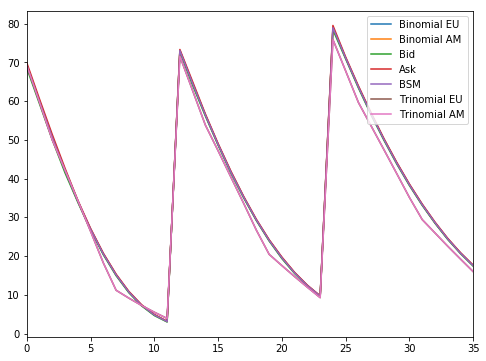

In [17]:
print (df.head())
df.plot(figsize=(8,6))

Plotting the Absolute error vs N

In [20]:
#Calculating the Absolute Error using the Trinomial Tree for the European Puts
def AbsError(S,K,r,t,sigma,type):
    
    N=[10,20,30,40,50,100,150,200,250,300,350,400]
    Err = []
    for i in range(0,len(N)):
        bs=BSMOption(S,K,t,r,sigma,type)
        ti=Trinomial(m.log(S),K,t,r,sigma,type,'EU',N[i])
        Err.append(abs(bs-ti))
    
    dfa = pd.DataFrame({'Error':Err,'N':N})
    print ("\n",dfa)
    plt.plot(N,Err)
    plt.show()
    plt.xlabel = "N:Number of steps"
    plt.ylabel = "Absolute Error"
    plt.title = "Absolute Error vs N"


        Error    N
0   0.269277   10
1   0.239260   20
2   0.229647   30
3   0.224912   40
4   0.222093   50
5   0.216505  100
6   0.214657  150
7   0.213735  200
8   0.213183  250
9   0.212816  300
10  0.212553  350
11  0.212357  400


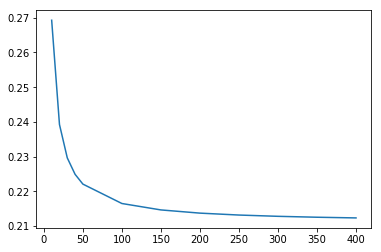

In [23]:
AbsError(S,k.loc[1],r,ttm.loc[1],iv[1],'c')

As we can observe above that the error has stagnated at N=200 and doesn't decrease anymore as the steps increase. 